# Import of useful libraries

In [2]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import concurrent.futures

/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparation

Given classifiers understand better when the target variable is at least ordinal, we switch our target class to integers; then we start creating the train-test split

In [3]:
tweets=pd.read_csv('cleantweets.csv', index_col=0)

In [4]:
class_dict={'not_cyberbullying': 0, 
            'age': 1, 
            'ethnicity': 2, 
            'religion': 3, 
            'gender': 4, 
            'other_cyberbullying': 5
            }

In [5]:
warnings.filterwarnings('ignore')
for i in range(len(tweets)): 
    tweets['cyberbullying_type'][i]=int(class_dict[tweets['cyberbullying_type'][i]])

In [6]:
x, y = tweets['cleantext'], tweets['cyberbullying_type']

Now we want to try and use pre loaded contextual word embeddings from sentence-BERT:

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
tweet_embeddings = model.encode(tweets['cleantext'], batch_size=64, show_progress_bar=True)

Batches: 100%|██████████| 709/709 [00:33<00:00, 21.30it/s]


In [9]:
x_train, x_test, y_train, y_test = train_test_split(tweet_embeddings, y, random_state=42)

In [10]:
y_train = y_train.reset_index(drop=True)  # reset index because otherwise the index will be the same as the original dataframe
y_test = y_test.reset_index(drop=True)  
y_train=y_train.astype('int') # convert to int because the classifier expects int
y_test=y_test.astype('int')

# Classification

## Xgboost

We now can test our first model, which will be XGBoost; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [11]:
n_folds = 7
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=6, random_state=4)

def evaluate_fold(train_idx, test_idx, x, y, model): # defining a function to evaluate the model while computing all the metrics in parallel
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train, y_train, xgb_clf) # parallelization of cross validation tasks
    for train_idx, test_idx in skf.split(x_train, y_train)
)

mean_metrics = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Mean Accuracy: 0.7922
Mean Precision: 0.7967
Mean Recall: 0.7922
Mean F1: 0.7940


In [12]:
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=6, random_state=4)
xgb_clf.fit(x_train, y_train)
y_pred_xgb = xgb_clf.predict(x_test)

In [13]:
print("XGBoost Accuracy:", accuracy_score(list(y_test.values), y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(list(y_test.values), y_pred_xgb))
print(class_dict)

XGBoost Accuracy: 0.7926291659319344
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.49      0.50      1798
           1       0.95      0.96      0.96      1977
           2       0.96      0.91      0.94      1875
           3       0.94      0.95      0.95      1961
           4       0.86      0.82      0.84      1926
           5       0.53      0.58      0.55      1805

    accuracy                           0.79     11342
   macro avg       0.79      0.79      0.79     11342
weighted avg       0.80      0.79      0.79     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


## MLP

We now can test our second model, which will be MLP; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [14]:
n_folds = 7
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
mlp_clf = MLPClassifier(activation='relu', solver='adam', learning_rate='adaptive', random_state=4)

def evaluate_fold(train_idx, test_idx, x, y, model): # defining a function to evaluate the model while computing all the metrics in parallel
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train, y_train, mlp_clf) # parallelization of cross validation tasks
    for train_idx, test_idx in skf.split(x_train, y_train)
)

mean_metrics = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anacond

Mean Accuracy: 0.7896
Mean Precision: 0.7897
Mean Recall: 0.7896
Mean F1: 0.7895


/opt/anaconda3/envs/LMDSclean/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
mlp_clf = MLPClassifier(activation='relu', solver='adam', learning_rate='adaptive', random_state=4)
mlp_clf.fit(x_train, y_train)
y_pred_mlp = mlp_clf.predict(x_test)

In [16]:
print("MLP Accuracy:", accuracy_score(list(y_test.values), y_pred_mlp))
print("MLP Classification Report:\n", classification_report(list(y_test.values), y_pred_mlp))
print(class_dict)

MLP Accuracy: 0.7888379474519485
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.47      0.48      1798
           1       0.95      0.96      0.96      1977
           2       0.95      0.93      0.94      1875
           3       0.94      0.93      0.94      1961
           4       0.83      0.84      0.84      1926
           5       0.52      0.57      0.54      1805

    accuracy                           0.79     11342
   macro avg       0.78      0.78      0.78     11342
weighted avg       0.79      0.79      0.79     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


## Decision Tree

We now can test our third model, which will be a decision tree; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [17]:
n_folds = 7
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
dt_clf = DecisionTreeClassifier().fit(x_train, y_train)

def evaluate_fold(train_idx, test_idx, x, y, model): # defining a function to evaluate the model while computing all the metrics in parallel
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train, y_train, dt_clf) # parallelization of cross validation tasks
    for train_idx, test_idx in skf.split(x_train, y_train)
)

mean_metrics = {metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

Mean Accuracy: 0.5986
Mean Precision: 0.6012
Mean Recall: 0.5986
Mean F1: 0.5996


In [18]:
y_pred_dt = dt_clf.predict(x_test)

In [19]:
print("XGBoost Accuracy:", accuracy_score(list(y_test.values), y_pred_dt))
print("XGBoost Classification Report:\n", classification_report(list(y_test.values), y_pred_dt))
print(class_dict)

XGBoost Accuracy: 0.5953094692294127
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.35      0.34      1798
           1       0.77      0.77      0.77      1977
           2       0.71      0.71      0.71      1875
           3       0.76      0.75      0.75      1961
           4       0.64      0.64      0.64      1926
           5       0.33      0.32      0.32      1805

    accuracy                           0.60     11342
   macro avg       0.59      0.59      0.59     11342
weighted avg       0.60      0.60      0.60     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


# Clustering

We are clustering because we want to check whether the resulting clusters will match or not the original classification; this will show us especially if classes overlap and, as a consequence, if some of the missclassified tweets are because of this "overlap". Moreover this can tell us more about the structure of hate speech in itself. 


The first thing we need to assess to proceed is the number of clusters K; to do this we decided to use the silhouette score, mainly because it does not rely on ground truths as required by what said above but also because it does not rely on the "structure" of the cluster not overlapping with other clusters or having a clear variance structure within its data. 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


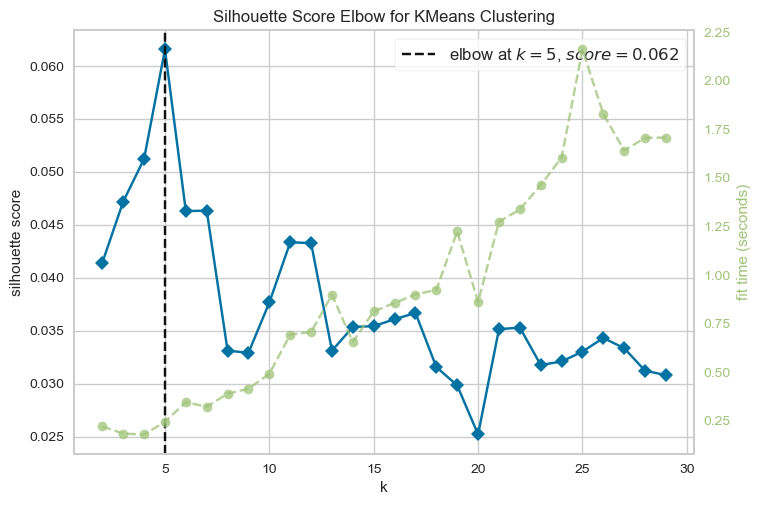

In [ ]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,30), metric='silhouette')
visualizer.fit(tweet_embeddings)
visualizer.show()
complete_k=visualizer.elbow_value_


Now remember that the silhouette Elbow method looks for when increasing K gives us diminishing returns considering also fit time in seconds. We do not care about fit time, and as such we shall choose K only based on the maximum this plot shows, which is for K=5.

Just as a double check, we can also look for the "distortion" as a metric, although we already know it will probably follow some multiple of the squared inverse of K, given that K is a good proxy for flexibility of the model and hence it's also a good proxy of the squared variance of the model.

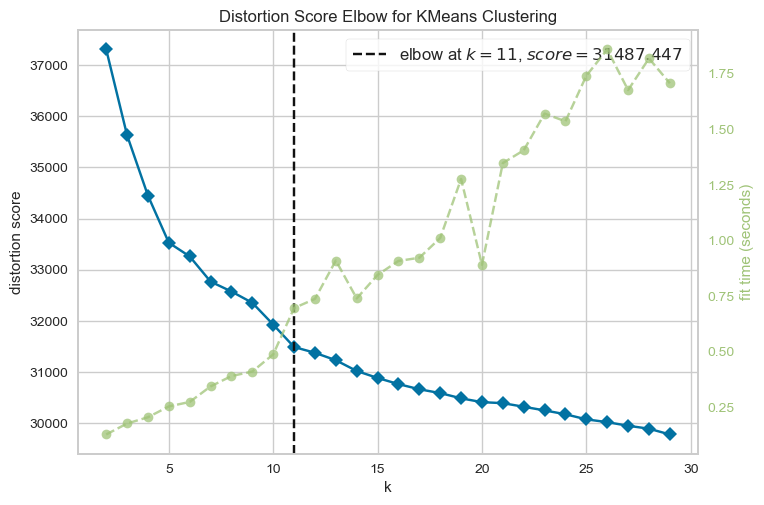

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,30), metric='distortion')
visualizer.fit(tweet_embeddings)
visualizer.show()

Choosing K=5 gives us also some advantage on the variance side given it already has fallen off quite a bit by then.

In [22]:
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=920)
kmeans.fit(tweet_embeddings)
clusters = kmeans.predict(tweet_embeddings)
tweets['cluster'] = clusters

An interesting plot we can take a look at is, for starters, frequency of tweets within clusters. We would expect this to be approximately constant if the classification was to follow our "ground truth":

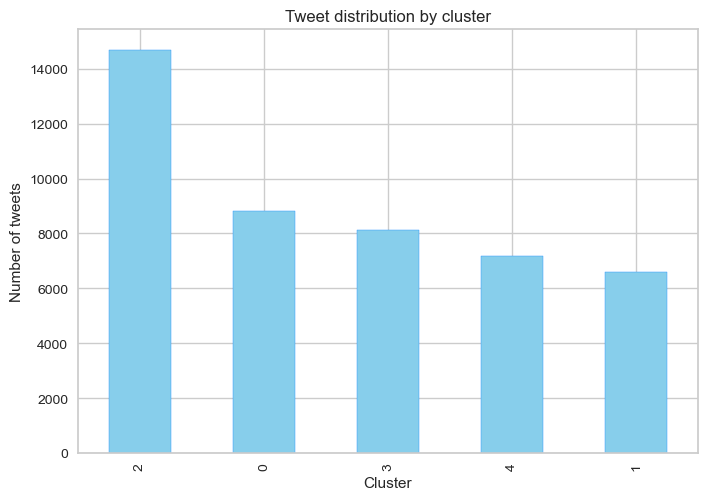

In [23]:
tweets['cluster'].value_counts().plot(kind='bar', color='skyblue', edgecolor='dodgerblue')
plt.title('Tweet distribution by cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of tweets')
plt.show()

Another metric we can compute is the Silhouette Score and the Adjusted Rand Index, which is basically a count of how many tweets were classified "correctly" based on our ground truth, accounting for random chance.

In [24]:
silhouette = silhouette_score(tweet_embeddings, kmeans.labels_)
print(f"Silhouette Coefficient: {silhouette:.2f}")

rand_index = adjusted_rand_score(tweets['cyberbullying_type'], tweets['cluster'])
print(f"Rand Index: {rand_index:.2f}")

Silhouette Coefficient: 0.06
Rand Index: 0.52


One interesting thing to do to see if clusters are well separated is to plot them along Principal Components Axis:

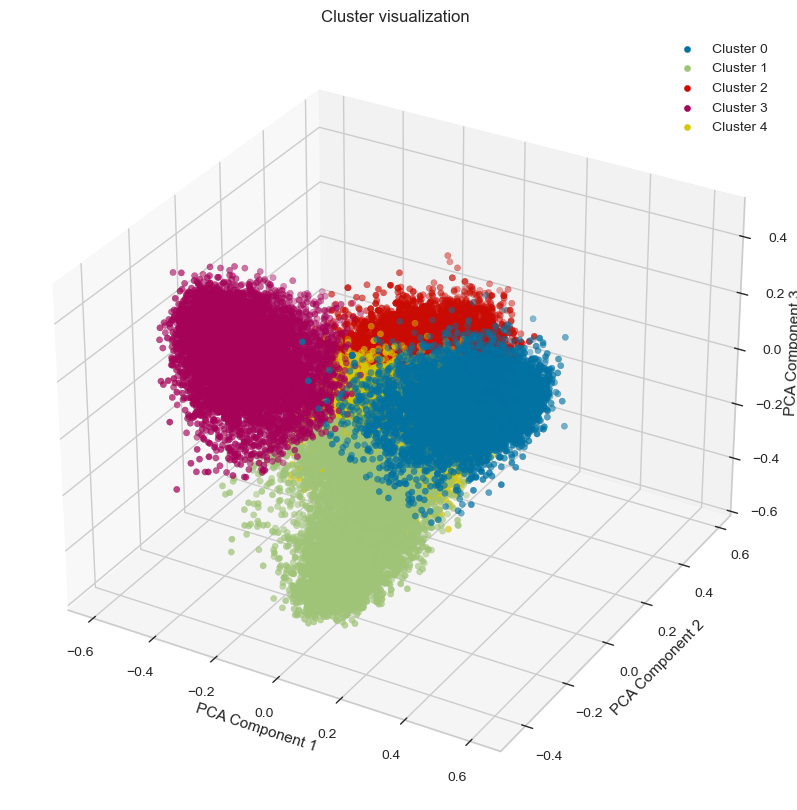

In [25]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(tweet_embeddings)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(num_clusters):
    ax.scatter(x_pca[tweets['cluster'] == cluster, 0], x_pca[tweets['cluster'] == cluster, 1], x_pca[tweets['cluster'] == cluster, 2], label=f'Cluster {cluster}')
ax.set_title('Cluster visualization')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()

## Clustering improvements by class deletion

It is interesting to notice that the number of clusters identificated for the best K using sentence-BERT is very similar to the actual number of clusters; in fact, the original number of clusters was 6 while the number of clusters identificated with sentence-BERT is 5. Moreover, the frequency of samples per class, except that for cluster "2", is close to 8000, very much similarly to the original number of tweets per each class! If we compute the IR index (used in preprocessing) excluding cluster "2" we have: 

In [39]:
IR=max(tweets[tweets['cluster']!=2].groupby('cluster').count()['cleantext'].values)/min(tweets[tweets['cluster']!=2].groupby('cluster').count()['cleantext'].values)
print('Imbalance Ratio:', IR)
print('Mean number of tweets per class: ', np.mean(tweets[tweets['cluster']!=2].groupby('cluster').count()['cleantext'].values))

Imbalance Ratio: 1.339668541888399
Mean number of tweets per class:  7667.75


Once again we see the distribution in classes, excluding class 2, is not particularly imbalanced and generally speaking close to 8000!

This could be interpreted as the sentence-BERT clustering actually "finding" once again our "original" clusters, and having instead some difficulty, which can be easily explained considering that the classes "other_cyberbullying" and "no_cyberbullying" might be not as well defined as the other classes, because they do not revolve around a specific topic but rather are more general. To see if this hypothesis is correct we can try to compute once again which is the best silhouette score and k number of clusters for our dataset but excluding one class at a time; this way we'll see if excluding the two classes associated with more noise will improve our dataset 

In [26]:
def process_class(i):
    tweets_reduced = tweets[tweets['cyberbullying_type'] != i]
    tweets_reduced.reset_index(inplace=True)
    tweets_reduced = tweets_reduced['cleantext']
    model = SentenceTransformer('all-MiniLM-L6-v2')
    tweet_embeddings = model.encode(tweets_reduced, batch_size=64, show_progress_bar=True)
    silhouette_scores = []
    k_range = range(2, 30)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=4)
        kmeans.fit(tweet_embeddings)
        score = silhouette_score(tweet_embeddings, kmeans.labels_)
        silhouette_scores.append(score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    return i, [optimal_k, max(silhouette_scores)]

diff_dict = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(process_class, class_dict.values())

for i, result in results:
    diff_dict[i] = result

Batches:   0%|          | 0/585 [00:00<?, ?it/s]


Batches:   0%|          | 1/585 [00:01<12:57,  1.33s/it]









Batches:   0%|          | 2/585 [00:02<12:20,  1.27s/it]









Batches:   1%|          | 3/585 [00:03<09:09,  1.06it/s]












Batches:   1%|          | 4/585 [00:03<07:13,  1.34it/s]









Batches:   1%|          | 5/585 [00:03<06:05,  1.58it/s]






Batches:   1%|          | 6/585 [00:04<05:17,  1.82it/s]












Batches:   1%|          | 7/585 [00:04<04:48,  2.01it/s]









Batches:   1%|▏         | 8/585 [00:05<04:34,  2.10it/s]






Batches:   2%|▏         | 9/585 [00:05<04:27,  2.15it/s]








Batches:   2%|▏         | 10/585 [00:06<04:24,  2.18it/s]









Batches:   2%|▏         | 11/585 [00:06<04:14,  2.26it/s]













Batches:   2%|▏         | 12/585 [00:06<04:15,  2.24it/s]








Batches:   2%|▏         | 13/585 [00:07<04:09,  2.29it/s]










Batches:   2%|▏         | 14/585 [00:07<04:05,  2.32it/s]








Batches:   3%|▎   

In [28]:
# defining a function that will prove useful later
def key_from_value(dict, search):
    for k, v in dict.items():
        if v == search:
            return k

One of the first thing we can take a look at is the average number of clusters we have for each best silhouette score computed removing a cluster: 

In [33]:
print('Average number of clusters: ', np.mean([diff_dict[i][0] for i in diff_dict.keys()]))

Average number of clusters:  6.166666666666667


Again, we observe it is very close to our original number of 6 classes. Now we will instead plot the best silhouette score obtained removing classes one by one, to show how it improves or worsen relative to the best silhouette score computed without removing any "noisy" class:

In [56]:
classes=[]
for x in diff_dict.keys():
	classes.append(key_from_value(class_dict, int(x)))
values=[diff_dict[x][1] for x in diff_dict.keys()]

In [64]:
kmeans = KMeans(n_clusters=complete_k, random_state=4)
kmeans.fit(tweet_embeddings)
silhouette_best_original = silhouette_score(tweet_embeddings, kmeans.labels_)

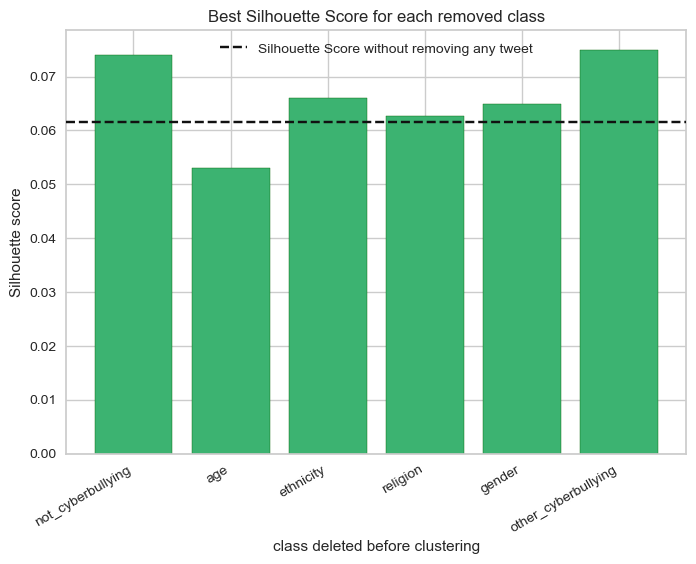

In [76]:
plt.bar(classes, values, color='mediumseagreen', edgecolor='darkgreen', zorder=2)
plt.xticks(rotation=30, ha='right')
plt.title('Best Silhouette Score for each removed class')
plt.grid(zorder=1)
plt.ylabel('Silhouette score')
plt.xlabel('class deleted before clustering')
plt.axhline(silhouette_best_original, color='k', linestyle='--', label='Silhouette Score without removing any tweet', zorder=3)
plt.legend()
plt.show()

This plot essentially confirms our suspicion: when removing "not_cyberbullying" and "other_cyberbullying" we see the silhouette score improving more than 15% compared to the baseline in both cases, and essentially staying the same or even worsening when removing the other classes. This is somewhat of a proof that sentence-BERT picked up our "original" classes! 